In [10]:
import os
import time
import itertools

import numpy as np
import pandas as pd

import ipyvolume as ipv
from pathlib import Path

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.draw.ipv_draw import view_ipv
from tyssue.core.sheet import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.solvers.sheet_vertex_solver import Solver


from invagination.ellipsoid import EllipsoidGeometry as geom
from invagination.ellipsoid import VitellineElasticity
from invagination.plots import (mesoderm_position,
                                panel_sagittal_view,
                               save_3_axis_plot,
                               save_ventral_plot)
from invagination.toolbox import (open_sheet,
                                  force_ratio,
                                  define_depth,
                                  define_time_max_depth,
                                  define_time_depth_compare_to_vivo,
                                 face_centered_patch)
from tyssue.draw.ipv_draw import sheet_view
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/SimulationsReview')
#SIM_DIR = Path('/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/')

old = None

In [27]:

dirname = SIM_DIR/'2018-07-18'
#target_dirname = Path('/home/admin-suz/Documents/SimulationsReview/')/'2018-07-12'
list_dir = np.sort(os.listdir(dirname))

list_dir

array(['1.08_contractility_5_critical_area_30_radialtension_10_width',
       '1.08_contractility_5_critical_area_30_radialtension_15_width',
       '1.08_contractility_5_critical_area_30_radialtension_20_width',
       '1.08_contractility_5_critical_area_30_radialtension_25_width',
       '1.08_contractility_5_critical_area_30_radialtension_30_width',
       '1.08_contractility_5_critical_area_30_radialtension_35_width'],
      dtype='<U60')

In [9]:
def mean_calculation(face, col):
    mean = []
    std = []
    val = []
    pas = 3
    for i in range(-50, 50):
        mean.append(face[(face['x'] > i) & (
            face['x'] < (i + pas))][col].mean())
        std.append(face[(face['x'] > i) & (
            face['x'] < (i + pas))][col].std())
        val.append(i)
    return val, mean, std

/home/admin-suz/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


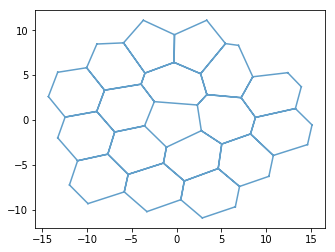

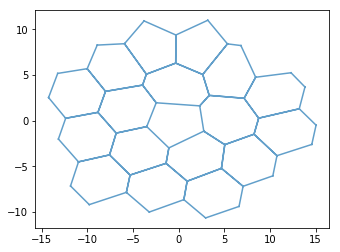

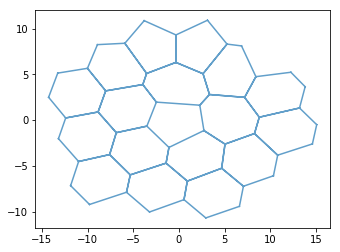

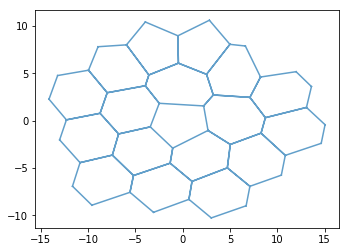

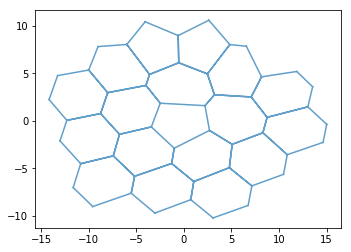

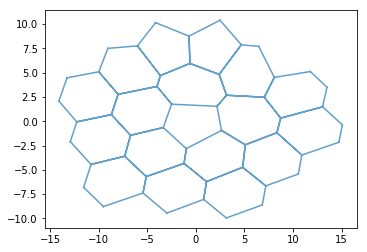

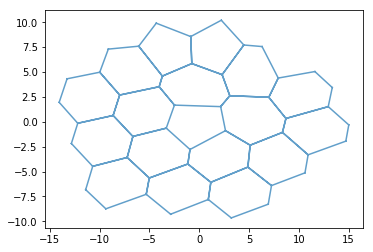

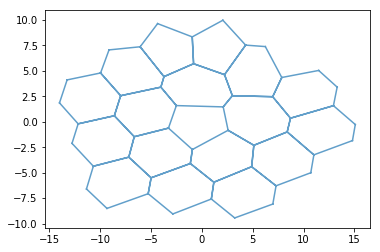

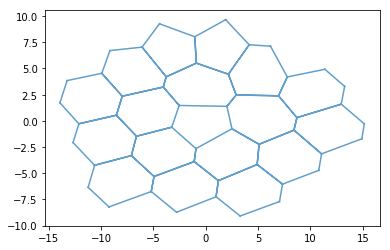

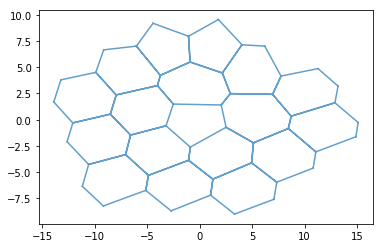

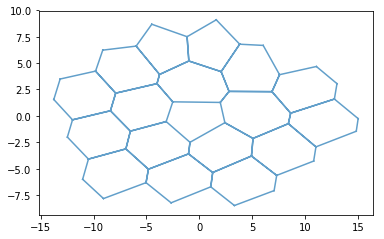

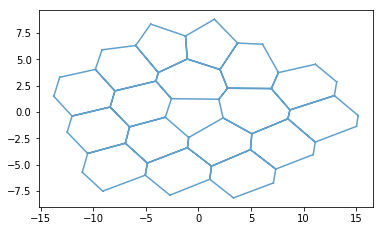

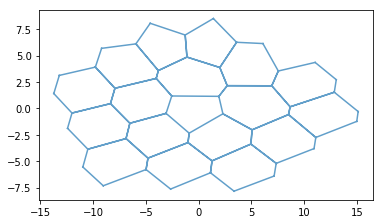

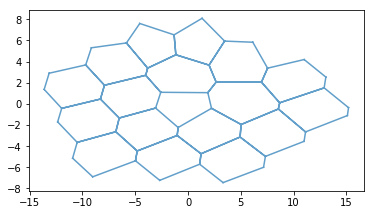

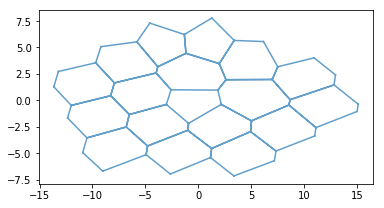

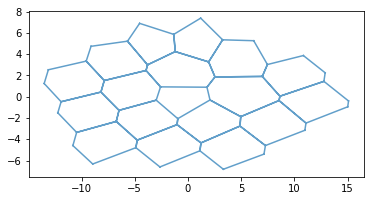

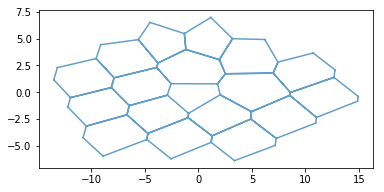

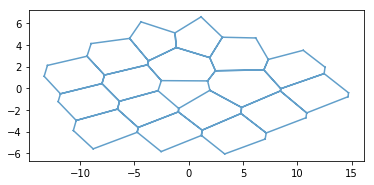

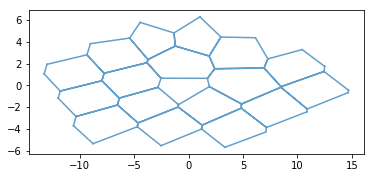

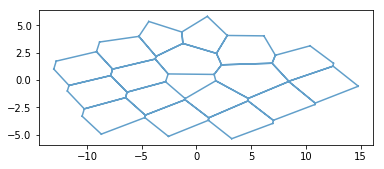

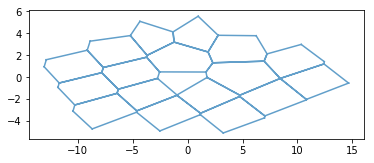

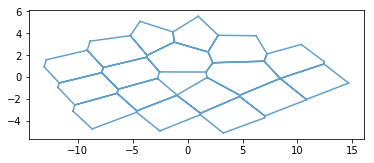

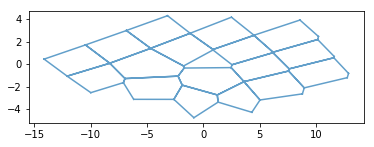

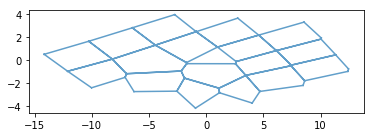

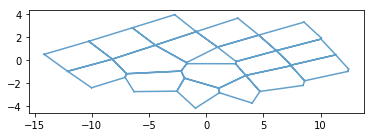

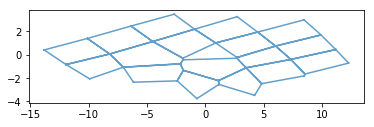

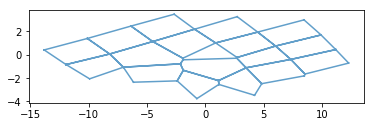

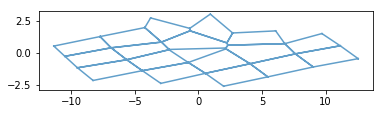

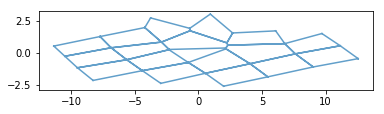

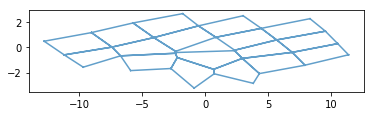

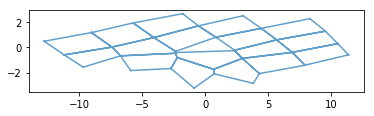

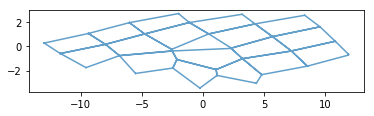

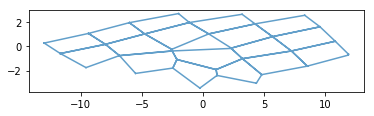

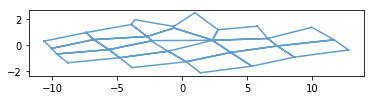

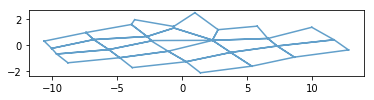

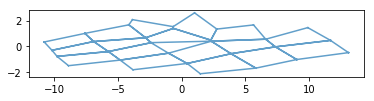

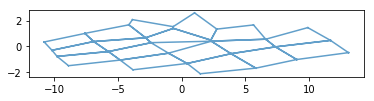

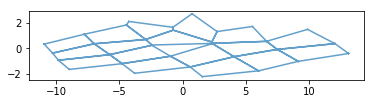

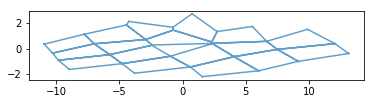

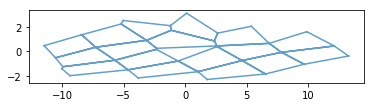

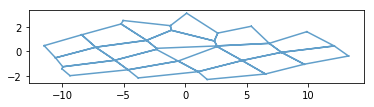

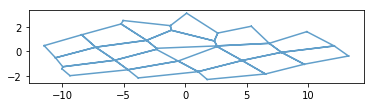

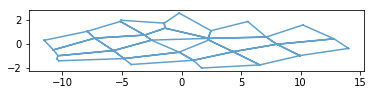

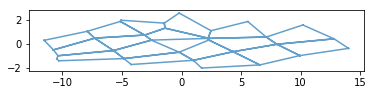

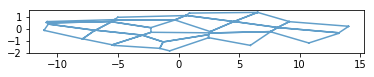

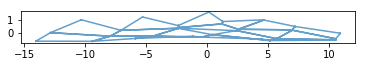

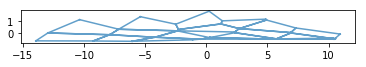

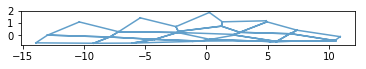

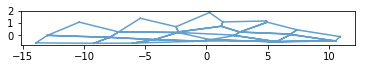

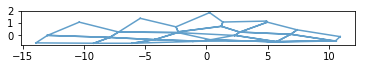

In [166]:
for t in range(0,50):
    sheet = open_sheet(os.path.join(dirname, list_dir[1]),t)
    patch = face_centered_patch(sheet, 53, 2)
    fig, ax = quick_edge_draw(patch, ['x', 'y'],
                              alpha=0.7)

1.08_contractility_5_critical_area_0_radialtension
1.08_contractility_5_critical_area_50_radialtension
1.32_contractility_5_critical_area_0_radialtension
1.32_contractility_5_critical_area_50_radialtension


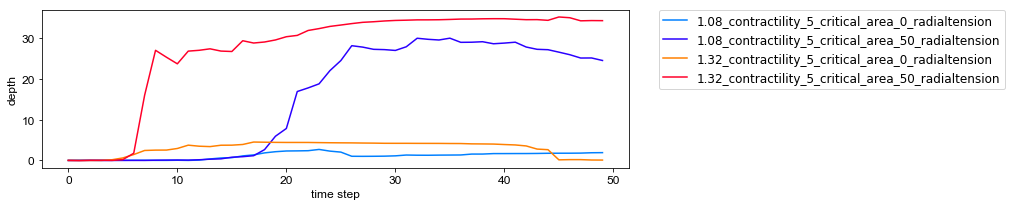

In [6]:
fig, ax1 = plt.subplots()
color_list = [(0.0, 0.5, 1.0, 1.0), 
              (0.16304347826086973, 0.0, 1.0, 1.0),
              (1.0, 0.5, 0.0, 1.0),
              (1.0, 0.0, 0.16, 1.0)
            ]
i=0
for d in list_dir:
    print (d)
    depth_0 = define_depth(os.path.join(dirname, d), 0, ['z', 'x'])
    depth=[]
    for t in range(0,50):
        depth.append(depth_0 - define_depth(os.path.join(dirname, d),t, ['z', 'x']))
        
    
    ax1.plot(depth,color=color_list[i],label = d)
    i=i+1
    
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'sans-serif'})


ax1.set_xlabel('time step', size=12, family='sans-serif', fontname='Arial')
ax1.set_ylabel('depth', size=12, family='sans-serif', fontname = 'Arial')
for tick in ax1.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax1.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

fig.set_size_inches(9, 3)
fig.savefig('../depth_time.svg', dpi = 150)





fig.tight_layout()
plt.show()

In [129]:
# nombre de cellule qui tirent au cours du temps :
list_nb_pulling_cell = []

sheet = open_sheet(os.path.join(dirname, list_dir[1]),0)
depth_0 = define_depth(os.path.join(dirname, list_dir[1]), 0, ['z', 'x'])
depth=[]
for t in range(0,50):
    sheet = open_sheet(os.path.join(dirname, list_dir[1]),t)
    depth.append(depth_0 - define_depth(os.path.join(dirname, list_dir[1]),t, ['z', 'x']))
    sheet.vert_df[sheet.vert_df.radial_tension>0]
    res=(sheet.edge_df[(sheet.edge_df.srce.isin(sheet.vert_df[sheet.vert_df.radial_tension>0].index))
                           &
                           (sheet.edge_df.trgt.isin(sheet.vert_df[sheet.vert_df.radial_tension>0].index))])
    for f in res.face.unique() : 
        if len(res[res.face==f]) == 1:
            res= res.drop(res[res.face==f].index)
    list_nb_pulling_cell.append(len(res.face.unique()))

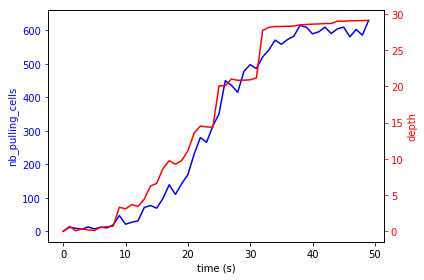

In [124]:
fig, ax1 = plt.subplots()
ax1.plot( list_nb_pulling_cell, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('nb_pulling_cells', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(depth, 'r-')
ax2.set_ylabel('depth', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

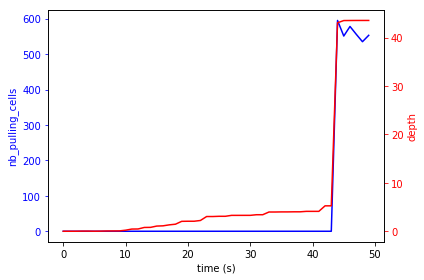

In [130]:
fig, ax1 = plt.subplots()
ax1.plot( list_nb_pulling_cell, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('nb_pulling_cells', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(depth, 'r-')
ax2.set_ylabel('depth', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


### Save ventral plots

1.08_contractility_5_critical_area_30_radialtension_10_width


KeyboardInterrupt: 

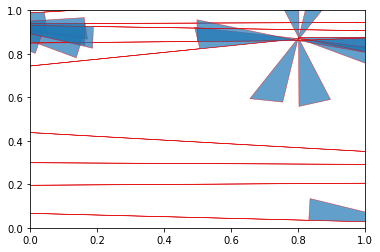

In [35]:
print (list_dir[0])        
save_ventral_plot(os.path.join(dirname, list_dir[2]), 
                  start=0, step=5, max_area=40,face_caracteristic='area',
                  face_color='Blues', edge_color='hot', 
                  edge_normalization=4)


In [25]:
for dir_ in list_dir:
    print (dir_)
    save_3_axis_plot(os.path.join(dirname, dir_),
                     0, 1)

1.08_contractility_5_critical_area_30_radialtension_10_width
1.08_contractility_5_critical_area_30_radialtension_15_width
1.08_contractility_5_critical_area_30_radialtension_20_width
1.08_contractility_5_critical_area_30_radialtension_25_width


In [7]:
sheet=open_sheet(os.path.join(dirname, list_dir[0]),10)
sheet.edge_df

,dz,ny,dx,nx,length,sub_vol,sub_area,srce,face,cell,...,edge_o,srce_o,trgt_o,face_o,cell_o,line_tension,is_active,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
0,-1.931008,2.408979,1.163360,5.444394,2.370521,133.872355,3.641339,11775,5795,0,...,69584,11775,11852,5795,5947,17.779449,True,0.490492,0.309176,-0.814756
1,5.239605,9.526492,0.125814,-4.426277,5.324365,154.488489,5.312778,11308,5810,0,...,69740,11308,11625,5810,5947,17.779449,True,0.023675,0.176372,0.984039
2,-2.373881,6.791412,-1.910005,-1.398170,3.058589,96.321271,3.471584,7592,4723,0,...,57050,7592,7593,4723,5947,17.779449,True,-0.624095,-0.087179,-0.776470
3,0.086766,-0.358633,0.033540,-0.014568,0.094129,5.342076,0.182392,857,1193,0,...,14826,857,856,1193,5947,17.779449,True,0.344902,0.162557,0.924455
4,-0.304191,5.547580,1.874344,-3.871172,2.268831,100.725555,3.435825,9653,4716,0,...,56980,9653,7570,4716,5947,17.779449,True,0.825785,0.547766,-0.134283
5,1.666614,7.973055,2.143898,-5.842146,3.269993,143.572020,4.978475,7567,4715,0,...,56964,7567,7566,4715,5947,17.779449,True,0.655622,0.557012,0.509801
6,-0.740332,-3.998497,1.227365,5.007001,2.036506,91.721167,3.213087,2985,1207,0,...,14992,2985,2988,1207,5947,17.779449,True,0.602864,0.710134,-0.363683
7,-2.229269,-5.118828,0.346202,3.054113,2.364048,99.366127,3.159356,2977,1205,0,...,14968,2977,881,1205,5947,17.779449,True,0.146605,-0.298812,-0.942984
8,-2.040559,4.619982,0.810757,-8.132045,3.841973,164.488325,5.068000,4294,743,0,...,9240,4294,7080,743,5947,17.779449,True,0.210949,0.820685,-0.531014


### Plot maximal depth according to force

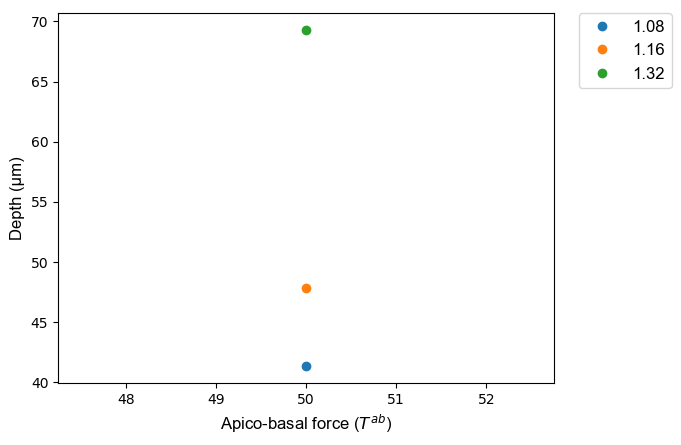

In [32]:
mpl.rcParams.update(mpl.rcParamsDefault)
contractility = ['1.08', '1.16', '1.32']
force = [ '50']

from invagination.toolbox import define_depth
def define_time_max_depth(directory, nb_t=200):
    """Define time and depth where the depths
    is maximal in a directory
    """
    depth_0 = define_depth(directory, 0, ['z', 'x'])

    depths = []
    for t in range(0, nb_t):
        try : 
            depths.append(depth_0 - define_depth(directory, t, ['z', 'x']))
        except Exception:
            depths.append(0)

    time = depths.index(max(depths))
    return time, max(depths)

fig, ax = plt.subplots()

for c in contractility : 
    stores = [f for f in list_dir if not(f.find(c))] 
    list_t = {}
    for fab in force : 
        file_directory = [f for f in stores if (f.find(str('_'+fab+'_')))>0] [0]
        
        t,d =  define_time_max_depth(os.path.join(dirname, file_directory))
        list_t[fab] = d
        
        #list_t[fab] = result_dataframe.loc[file_directory,'depth']
    
    
    ax.plot ([int (u)for u in list_t.keys()], [float (u)for u in list_t.values()], 
             '.',markersize=12, label = round(float(c), 2))


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})
ax.set_xlabel('Apico-basal force ($T^{ab}$)', size=12, family='Arial')
ax.set_ylabel('Depth (µm)', size=12, family='Arial')
fig.savefig('../depth_contractility.svg', dpi = 300)

## Plot pannel for principal figure

In [247]:
import matplotlib
matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))

fig = plt.figure(figsize=(20, 20))
grid = gridspec.GridSpec(5, 5, wspace=0.0, hspace=0.0)

axes_1_1 = fig.add_subplot(grid[0, 0])
axes_1_2 = fig.add_subplot(grid[0, 1])
axes_1_3 = fig.add_subplot(grid[0, 2])
axes_1_4 = fig.add_subplot(grid[0, 3])
axes_1_5 = fig.add_subplot(grid[0, 4])
axes_2_1 = fig.add_subplot(grid[1, 0])
axes_2_2 = fig.add_subplot(grid[1, 1])
axes_2_3 = fig.add_subplot(grid[1, 2])
axes_2_4 = fig.add_subplot(grid[1, 3])
axes_2_5 = fig.add_subplot(grid[1, 4])
axes_3_1 = fig.add_subplot(grid[2, 0])
axes_3_2 = fig.add_subplot(grid[2, 1])
axes_3_3 = fig.add_subplot(grid[2, 2])
axes_3_4 = fig.add_subplot(grid[2, 3])
axes_3_5 = fig.add_subplot(grid[2, 4])
axes_4_1 = fig.add_subplot(grid[3, 0])
axes_4_2 = fig.add_subplot(grid[3, 1])
axes_4_3 = fig.add_subplot(grid[3, 2])
axes_4_4 = fig.add_subplot(grid[3, 3])
axes_4_5 = fig.add_subplot(grid[3, 4])
axes_5_1 = fig.add_subplot(grid[4, 0])
axes_5_2 = fig.add_subplot(grid[4, 1])
axes_5_3 = fig.add_subplot(grid[4, 2])
axes_5_4 = fig.add_subplot(grid[4, 3])
axes_5_5 = fig.add_subplot(grid[4, 4])

panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_0_radialtension/' , result_dataframe, axes_1_1)
panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_25_radialtension/', result_dataframe, axes_1_2)
panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_50_radialtension/', result_dataframe, axes_1_3)
panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_75_radialtension/', result_dataframe, axes_1_4)
panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_100_radialtension/', result_dataframe, axes_1_5)

panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_0_radialtension/' , result_dataframe, axes_2_1)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_25_radialtension/', result_dataframe, axes_2_2)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_50_radialtension/', result_dataframe, axes_2_3)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_75_radialtension/', result_dataframe, axes_2_4)
panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_100_radialtension/', result_dataframe, axes_2_5)

panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_0_radialtension/' , result_dataframe, axes_3_1)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_25_radialtension/', result_dataframe, axes_3_2)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_50_radialtension/', result_dataframe, axes_3_3)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_75_radialtension/', result_dataframe, axes_3_4)
panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_100_radialtension/', result_dataframe, axes_3_5)

panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_0_radialtension/' , result_dataframe, axes_4_1)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_25_radialtension/', result_dataframe, axes_4_2)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_50_radialtension/', result_dataframe, axes_4_3)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_75_radialtension/', result_dataframe, axes_4_4)
panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_100_radialtension/', result_dataframe, axes_4_5)

panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_0_radialtension/' , result_dataframe, axes_5_1)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_25_radialtension/', result_dataframe, axes_5_2)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_50_radialtension/', result_dataframe, axes_5_3)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_75_radialtension/', result_dataframe, axes_5_4)
panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_100_radialtension/', result_dataframe, axes_5_5)


axes_1_1.set_ylabel('64', size=20, family='Arial')
axes_2_1.set_ylabel('32', size=20, family='Arial')
axes_3_1.set_ylabel('16', size=20, family='Arial')
axes_4_1.set_ylabel('8', size=20, family='Arial')
axes_5_1.set_ylabel('4', size=20, family='Arial')


axes_5_1.set_xlabel('0', size=20, family='Arial')
axes_5_2.set_xlabel('25', size=20, family='Arial')
axes_5_3.set_xlabel('50', size=20, family='Arial')
axes_5_4.set_xlabel('75', size=20, family='Arial')
axes_5_5.set_xlabel('100', size=20, family='Arial')

#plt.savefig('../paper/contract_force.svg', dpi = 300)
#result_dataframe.to_csv('result_principal_result.csv')

#### Film from principal fig

In [15]:
def panel_sagittal_view(directory, df, t, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

        
    list_t = {'1.04_contractility_5_critical_area_0_radialtension':41,
             '1.6400000000000001_contractility_5_critical_area_75_radialtension':37,
             '1.16_contractility_5_critical_area_75_radialtension':20,
             '1.32_contractility_5_critical_area_25_radialtension':40,
             '1.08_contractility_5_critical_area_100_radialtension':32,
             '1.32_contractility_5_critical_area_100_radialtension':37,
             '1.6400000000000001_contractility_5_critical_area_0_radialtension':38,
             '1.04_contractility_5_critical_area_75_radialtension':56,
             '1.04_contractility_5_critical_area_25_radialtension':110,
             '1.16_contractility_5_critical_area_0_radialtension':25,
             '1.08_contractility_5_critical_area_75_radialtension':32,
             '1.08_contractility_5_critical_area_25_radialtension':52,
             '1.16_contractility_5_critical_area_25_radialtension':46,
             '1.6400000000000001_contractility_5_critical_area_25_radialtension':34,
             '1.04_contractility_5_critical_area_50_radialtension':57,
             '1.32_contractility_5_critical_area_0_radialtension':17,
             '1.04_contractility_5_critical_area_100_radialtension':73,
             '1.08_contractility_5_critical_area_50_radialtension':35,
             '1.08_contractility_5_critical_area_0_radialtension':23,
             '1.32_contractility_5_critical_area_75_radialtension':42,
             '1.16_contractility_5_critical_area_100_radialtension':46,
             '1.16_contractility_5_critical_area_50_radialtension':34,
             '1.6400000000000001_contractility_5_critical_area_50_radialtension':36,
             '1.32_contractility_5_critical_area_50_radialtension':45,
             '1.6400000000000001_contractility_5_critical_area_100_radialtension':28}
        
    if t > list_t[str(directory).split('/')[-1]] :
        t = list_t[str(directory).split('/')[-1]] 
    sheet = tb.open_sheet(directory, t)

    # sagital view
    fig, ax = bp.sagittal_view(
        sheet, -5, 5, 'is_mesoderm', ['x', 'y'], 'z', ax)
    a, c = 87, 87
    thetas = np.linspace(0, 2 * np.pi)
    ax.plot(c * np.cos(thetas), a * np.sin(thetas), color='grey', alpha=0.7)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    
    ax.text(1, 2, t, horizontalalignment = 'center', verticalalignment = 'center', fontsize=18)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([]) 
    ax.set_xticks([]) 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
       

        
import matplotlib
matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))
for t in range (0,110):
    fig = plt.figure(figsize=(20, 20))
    grid = gridspec.GridSpec(5, 5, wspace=0.0, hspace=0.0)

    axes_1_1 = fig.add_subplot(grid[0, 0])
    axes_1_2 = fig.add_subplot(grid[0, 1])
    axes_1_3 = fig.add_subplot(grid[0, 2])
    axes_1_4 = fig.add_subplot(grid[0, 3])
    axes_1_5 = fig.add_subplot(grid[0, 4])
    axes_2_1 = fig.add_subplot(grid[1, 0])
    axes_2_2 = fig.add_subplot(grid[1, 1])
    axes_2_3 = fig.add_subplot(grid[1, 2])
    axes_2_4 = fig.add_subplot(grid[1, 3])
    axes_2_5 = fig.add_subplot(grid[1, 4])
    axes_3_1 = fig.add_subplot(grid[2, 0])
    axes_3_2 = fig.add_subplot(grid[2, 1])
    axes_3_3 = fig.add_subplot(grid[2, 2])
    axes_3_4 = fig.add_subplot(grid[2, 3])
    axes_3_5 = fig.add_subplot(grid[2, 4])
    axes_4_1 = fig.add_subplot(grid[3, 0])
    axes_4_2 = fig.add_subplot(grid[3, 1])
    axes_4_3 = fig.add_subplot(grid[3, 2])
    axes_4_4 = fig.add_subplot(grid[3, 3])
    axes_4_5 = fig.add_subplot(grid[3, 4])
    axes_5_1 = fig.add_subplot(grid[4, 0])
    axes_5_2 = fig.add_subplot(grid[4, 1])
    axes_5_3 = fig.add_subplot(grid[4, 2])
    axes_5_4 = fig.add_subplot(grid[4, 3])
    axes_5_5 = fig.add_subplot(grid[4, 4])


    dirname = SIM_DIR/'2018-05-29_principal_results'

    panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_0_radialtension/' , result_dataframe, t, axes_1_1)
    panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_25_radialtension/', result_dataframe,t, axes_1_2)
    panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_50_radialtension/', result_dataframe,t, axes_1_3)
    panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_75_radialtension/', result_dataframe,t, axes_1_4)
    panel_sagittal_view(dirname/'1.6400000000000001_contractility_5_critical_area_100_radialtension/', result_dataframe,t, axes_1_5)

    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_0_radialtension/' , result_dataframe,t, axes_2_1)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_25_radialtension/', result_dataframe, t,axes_2_2)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_50_radialtension/', result_dataframe,t, axes_2_3)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_75_radialtension/', result_dataframe,t, axes_2_4)
    panel_sagittal_view(dirname/'1.32_contractility_5_critical_area_100_radialtension/', result_dataframe, t,axes_2_5)

    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_0_radialtension/' , result_dataframe, t,axes_3_1)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_25_radialtension/', result_dataframe,t, axes_3_2)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_50_radialtension/', result_dataframe,t, axes_3_3)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_75_radialtension/', result_dataframe,t, axes_3_4)
    panel_sagittal_view(dirname/'1.16_contractility_5_critical_area_100_radialtension/', result_dataframe, t,axes_3_5)

    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_0_radialtension/' , result_dataframe,t, axes_4_1)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_25_radialtension/', result_dataframe,t, axes_4_2)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_50_radialtension/', result_dataframe,t, axes_4_3)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_75_radialtension/', result_dataframe,t, axes_4_4)
    panel_sagittal_view(dirname/'1.08_contractility_5_critical_area_100_radialtension/', result_dataframe,t, axes_4_5)

    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_0_radialtension/' , result_dataframe,t, axes_5_1)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_25_radialtension/', result_dataframe,t, axes_5_2)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_50_radialtension/', result_dataframe, t,axes_5_3)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_75_radialtension/', result_dataframe,t, axes_5_4)
    panel_sagittal_view(dirname/'1.04_contractility_5_critical_area_100_radialtension/', result_dataframe, t,axes_5_5)


    axes_1_1.set_ylabel('64', size=20, family='Arial')
    axes_2_1.set_ylabel('32', size=20, family='Arial')
    axes_3_1.set_ylabel('16', size=20, family='Arial')
    axes_4_1.set_ylabel('8', size=20, family='Arial')
    axes_5_1.set_ylabel('4', size=20, family='Arial')


    axes_5_1.set_xlabel('0', size=20, family='Arial')
    axes_5_2.set_xlabel('25', size=20, family='Arial')
    axes_5_3.set_xlabel('50', size=20, family='Arial')
    axes_5_4.set_xlabel('75', size=20, family='Arial')
    axes_5_5.set_xlabel('100', size=20, family='Arial')

    plt.savefig('../paper/temp_film/contract_force'+str(t)+'.png', dpi = 150)

    plt.close('all')

# compared morphometry

In [13]:
from invagination.morphometry import (parse_ply, 
                                      get_borders, 
                                      get_morphometry,
                                      get_ventral_patch,
                                      analyse,
                                      grided_graph,
                                      color_plot_silico,
                                      color_plot_vivo)

base_dir = '/media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo'

#### Morphometry from experiments

In [14]:


print('Data sub-directories:')
print('\t', *os.listdir(base_dir), sep='\n\t')
print('----------')
data_dirs = []
for tree in os.walk(base_dir):
    if not tree[1]: # only dir without subdirs
        data_dirs.append((Path(tree[0]), tree[-1]))
data_dir = data_dirs[:][0]

# Collected in vivo 
collected_vivo = {}
for data_dir in data_dirs:
    print(f'Treating {data_dir[0]}')
    figures, axes = None, None
    plys = [f for f in data_dir[1] if f.endswith('.ply')]
    for data_file in plys:
        basename = '_'.join((data_dir[0].parent.stem.replace(' ', ''),
                             Path(plys[0]).stem))
        try:
            dir_name_vivo = data_file.split('_')[0]
            print (dir_name_vivo)
            centers, figures, axes = analyse(data_dir[0], data_file,
                                             basename=basename,
                                             figures=figures, 
                                             axes=axes,
                                             show=True,
                                             save=True)
            centers.x = centers.x
            collected_vivo[basename] = centers
        except Exception as e:
            print(f'Failed for {basename}')
            print(type(e))
            print(e)

    plt.close('all')


Data sub-directories:
	
	20161108
	20170519
	20170531
----------
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20161108
20161108
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20170519
20170519
Treating /media/admin-suz/Sophie/2018/Papiers-EMT-Melanie/datas/MorphographX/EmbryonsInVivo/20170531
20170531


In [15]:
# In vivo shift
in_vivo_shift = {'20161108' : 15, '20170519':-12, '20170531':35}
for name, centers in collected_vivo.items():
    centers['x'] = centers['x'] + in_vivo_shift[name.split('_')[1]]
    
# Area normalisation
for name, centers in collected_vivo.items():
    centers['area'] = centers['area']/centers['area'].mean()

# Symetriser 
means={}
stds={}
for name, centers in collected_vivo.items():
    centers['abs_x'] = np.abs(centers.x)
    centers['bin'] = np.digitize(centers['abs_x'], np.arange(0, 130, 3))
    means[name]=centers.groupby('bin').mean()
    means[name]['bin'] = means[name].index
    stds[name]=centers.groupby('bin').std()
    stds[name]['bin'] = stds[name].index

#### Morphometry from simulation

In [29]:

from tyssue import Sheet, SheetGeometry, config
from tyssue.io import hdf5
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view


sim_data_dirs =Path('/home/admin-suz/Documents/SimulationsReview/2018-07-18')

chosen_repository = ['1.08_contractility_5_critical_area_30_radialtension_10_width',
                    '1.08_contractility_5_critical_area_30_radialtension_15_width',
                    '1.08_contractility_5_critical_area_30_radialtension_20_width',
                    '1.08_contractility_5_critical_area_30_radialtension_25_width',
                    '1.08_contractility_5_critical_area_30_radialtension_30_width',
                    '1.08_contractility_5_critical_area_30_radialtension_35_width']

cup_stage_dataframe = pd.DataFrame(index = chosen_repository,
                                   columns = ('time', 'depth', 'Fab/Fc'))


# Find cup stage for the chosen repository
for repo in chosen_repository:
    t, d = define_time_depth_compare_to_vivo(os.path.join(sim_data_dirs, repo), 200)
    #t, d = define_time_max_depth(os.path.join(sim_data_dirs, repo), 200)
    cup_stage_dataframe.loc[repo, 'time'] = t
    cup_stage_dataframe.loc[repo, 'depth'] = d
    sheet = open_sheet(os.path.join(sim_data_dirs, repo), t)
    cup_stage_dataframe.loc[repo, 'Fab/Fc'] = force_ratio(sheet)


hf5s = {}
for data_dir in chosen_repository :
    stores = [f for f in os.listdir(os.path.join(sim_data_dirs,data_dir)) if f.endswith('hf5')]
    stores.sort()

    time_index = cup_stage_dataframe.loc[data_dir,'time']
    
    hf5names = [stores[time_index]]
    hf5s[data_dir] = hf5names


In [30]:
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view

def get_ventral_patch2(fname):

    sim_dsets = hdf5.load_datasets(fname)
    sheet = Sheet('morph', sim_dsets,
                  config.geometry.flat_sheet())
    to_crop = sheet.cut_out([[-300, 300],
                             [sheet.vert_df.y.max()-60,
                              sheet.vert_df.y.max()+1],
                             [-300, 300]],)

    sheet.remove(to_crop)
    sheet.vert_df[['x', 'y', 'z']] = sheet.vert_df[['x', 'z', 'y']]
    SheetGeometry.update_all(sheet)
    return sheet
def fig_silico(data_dir, fname, basename='',
            save=True, plot=True, show=False,
            figures=None, axes=None):
    draw_specs = config.draw.sheet_spec()
    
    sheet = get_ventral_patch2(data_dir/fname)

    data_container = sheet.extract_bounding_box(
        y_boundary = (-50,50), x_boundary=(-50, 50))
    borders = data_container.upcast_srce(
        data_container.vert_df[data_container.coords])
    borders['label'] = data_container.edge_df['face']
    draw_specs['face']['visible'] = True
    draw_specs['face']['alpha'] = 1.
    draw_specs['face']['colormap'] = 'Blues'
    
    draw_specs['edge']['visible'] = True
    draw_specs['edge']['color'] = 'black'
    draw_specs['edge']['alpha'] = 0.8
    
    draw_specs['vert']['visible'] = False
    

    centers = get_morphometry(borders)
    
    print(centers.shape)
    print(data_container.face_df.shape)
    coords = ['x', 'y']

    for col in [ 'area']:
        if col == 'area':
            
            #cmap = plt.cm.get_cmap('Blues')
            #color_cmap = cmap(centers[col]/np.mean(centers[col]))
            draw_specs['face']['color'] = centers[col]/np.mean(centers[col])
            draw_specs['face']['color_range'] = (0, 2)
        
        
        fig, ax = sheet_view(data_container, ['x', 'y'],
                             **draw_specs)
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
        if save:
            fig.savefig(f'{basename}_{col}2.png', dpi=300)
        if not show:
            plt.close("all")

    return centers, figures, axes

In [36]:
cup_stage_dataframe

,time,depth,Fab/Fc
1.08_contractility_5_critical_area_30_radialtension_10_width,194,3.93957,0
1.08_contractility_5_critical_area_30_radialtension_15_width,110,4.44768,0
1.08_contractility_5_critical_area_30_radialtension_20_width,53,4.92762,0
1.08_contractility_5_critical_area_30_radialtension_25_width,52,4.47627,0
1.08_contractility_5_critical_area_30_radialtension_30_width,40,4.7234,0
1.08_contractility_5_critical_area_30_radialtension_35_width,36,3.83791,0


In [31]:
collected_silico = {}
for base_dir, stores in hf5s.items():
    base_dir = Path(os.path.join(sim_data_dirs, base_dir))
    print(f'Treating {base_dir.as_posix()}')
    for store in stores:
        basename = '_'.join((str(base_dir).split('/')[-1], Path(store).stem))
        #analyse(...)
        centers, figures, axes = fig_silico(base_dir, store,
                                         basename=basename,
                                         figures=None, 
                                         axes=None,
                                         show=True,
                                         save=True)
        collected_silico[basename] = centers
    plt.close('all')

Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_10_width
(517, 7)
(517, 20)
Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_15_width
(546, 7)
(546, 20)
Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_20_width
(572, 7)
(572, 20)
Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_25_width
(575, 7)
(575, 20)
Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_30_width
(574, 7)
(574, 20)
Treating /home/admin-suz/Documents/SimulationsReview/2018-07-18/1.08_contractility_5_critical_area_30_radialtension_35_width
(550, 7)
(550, 20)


In [32]:
rollings_silico = {name: centers.sort_values('x').rolling(window=20)
                   for name, centers in collected_silico.items()}

In [33]:
def in_vivo_plot (means, stds, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    collected_means = pd.concat(means, ignore_index=True)
    collected_stds = pd.concat(stds, ignore_index=True)
    
    mean = collected_means.groupby('bin').mean()
    std = collected_means.groupby('bin').std().dropna()

    
    val=np.concatenate((-mean['abs_x'][0:len(std)][::-1], mean['abs_x'][0:len(std)]))
    
    
    val2 = np.concatenate(((mean[column] - std[column])[0:len(std)][::-1], 
                           (mean[column] - std[column])[0:len(std)]))
    val3 = np.concatenate(((mean[column] + std[column])[0:len(std)][::-1], 
                           (mean[column] + std[column])[0:len(std)]))

    ax.fill_between(val, val2,  
                        val3,
                        color="linen") 
    ax.plot(val, np.concatenate((mean[column][0:len(std)][::-1], mean[column][0:len(std)])), label='in vivo',color= 'black')
    
    
def in_silico_plot (rollings_silico, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    for name, rol in rollings_silico.items():
        time = name.split('_')[-1][-2:]
        dir_name_silico = name.split('_invagination')[0]

        if normalized : 
            df_silico = pd.DataFrame({'x':rol.x.mean(),
                                    column:rol[column].mean() /rol[column].mean().mean()})
        else :
            df_silico = pd.DataFrame({'x':rol.x.mean(),
                                column:rol[column].mean()})
       
        val, mean, std = mean_calculation(df_silico, column)
        mean_r = mean[::-1]
        mean_mean = [(mean[i]+mean_r[i])/2 for i in range(len(mean))]


        ax.plot(val, mean_mean, label=label_dict[dir_name_silico], color = color_d[dir_name_silico])
    
    

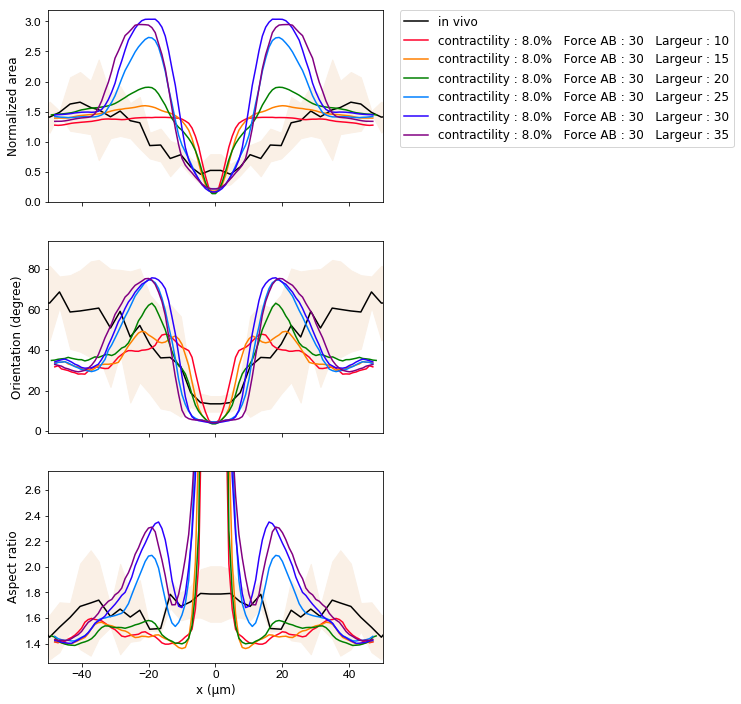

In [34]:
fig, (ax_area, ax_orient, ax_ar) = plt.subplots(3, 1, sharex=True, sharey=False)


# Add mean in vivo curve  
in_vivo_plot (means, stds, 'area', normalized=True, ax=ax_area)
in_vivo_plot (means, stds, 'orient', normalized=False, ax=ax_orient)
in_vivo_plot (means, stds, 'ar', normalized=False, ax=ax_ar)


jet = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=len(rollings_silico.items()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

color_d={}
i=0
color_list = [(0.0, 0.5, 1.0, 1.0),
              (0.0, 0.0, 1.0, 1.0),
              (1.0, 0.5, 0.0, 1.0),
              (1.0, 0.0, 0.0, 1.0)]
color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]

for name, rol in rollings_silico.items():
    dir_name_vivo = name.split('_invagination')[0]
    color_d[dir_name_vivo] = color_list[i]
    i=i+1
    
label_dict = {}
for repo in chosen_repository:
    label_dict[repo] = ("contractility : " + str(round((float(repo.split('_')[0])-1)*100,0)) +
                            '%   Force AB : ' + str(repo.split('_')[5])+
                            '   Largeur : ' + str(repo.split('_')[7]))
    


# Add in silico results
in_silico_plot(rollings_silico, 'area', normalized=True, ax=ax_area)
in_silico_plot(rollings_silico, 'orient', normalized=False, ax=ax_orient)
in_silico_plot(rollings_silico, 'ar', normalized=False, ax=ax_ar)

   
    
ax_area.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'sans-serif'})

ax_area.set_ylabel('Normalized area', size=12, family='sans-serif')
for tick in ax_area.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_area.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
    
ax_orient.set_ylabel('Orientation (degree)', size=12, family='sans-serif')
for tick in ax_orient.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_orient.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
    
ax_ar.set_xlabel('x (µm)', size=12, family='sans-serif')
ax_ar.set_ylabel('Aspect ratio', size=12, family='sans-serif')
ax_ar.set_ylim(1.25, 2.75)
ax_ar.set_xlim(-50, 50)
for tick in ax_ar.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax_ar.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

fig.set_size_inches(6, 12)
fig.savefig('../morphoemtry_principal_result.svg', dpi = 150)

In [23]:
def mean_calculation(face, col, range_min=-50, range_max=50): 
    mean = [] 
    std = [] 
    val = [] 
    pas = 3 
    for i in range(range_min, range_max): 
        mean.append(face[(face['x'] > i) & ( 
            face['x'] < (i + pas))][col].mean()) 
        std.append(face[(face['x'] > i) & ( 
            face['x'] < (i + pas))][col].std()) 
        val.append(i) 
    return val, mean, std 

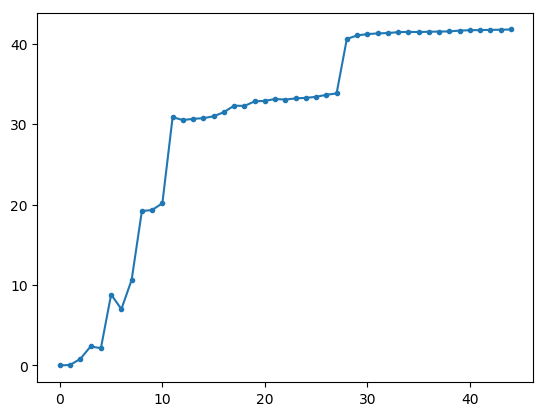

In [111]:
from invagination.toolbox import define_depth 
depth0 = define_depth(os.path.join(sim_data_dirs, '1.32_contractility_5_critical_area_50_radialtension'), 0, ['z', 'x'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
res_d = []
for t in range (0,45):
    res_d.append(depth0 - define_depth(os.path.join(sim_data_dirs, '1.32_contractility_5_critical_area_50_radialtension'), t, ['z', 'x']))
ax.plot ( res_d, '.-')

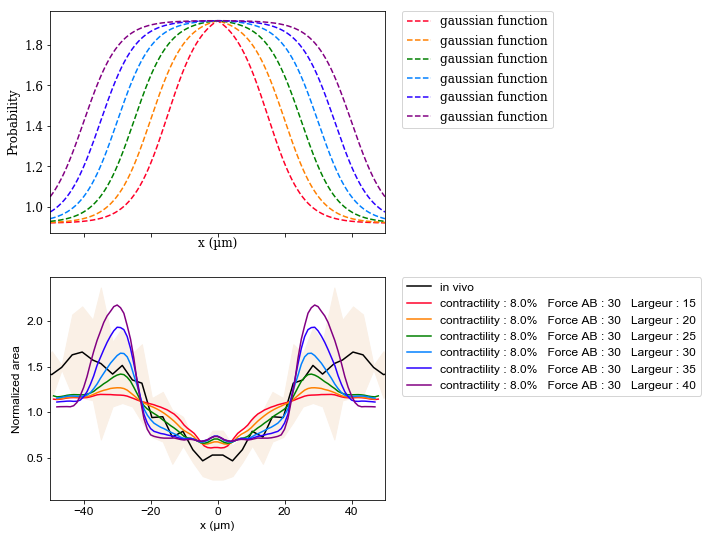

In [49]:
def in_vivo_plot (means, stds, column, normalized=False, ax=None):
    if ax is None : 
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    collected_means = pd.concat(means, ignore_index=True)
    collected_stds = pd.concat(stds, ignore_index=True)
    
    mean = collected_means.groupby('bin').mean()
    std = collected_means.groupby('bin').std().dropna()

    
    val=np.concatenate((-mean['abs_x'][0:len(std)][::-1], mean['abs_x'][0:len(std)]))
    
    
    val2 = np.concatenate(((mean[column] - std[column])[0:len(std)][::-1], 
                           (mean[column] - std[column])[0:len(std)]))
    val3 = np.concatenate(((mean[column] + std[column])[0:len(std)][::-1], 
                           (mean[column] + std[column])[0:len(std)]))

    ax.fill_between(val, val2,  
                        val3,
                        color="linen") 
    ax.plot(val, np.concatenate((mean[column][0:len(std)][::-1], mean[column][0:len(std)])), label='in vivo',color= 'black')
    



import itertools
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np


fig, (ax_init, ax) = plt.subplots(2, 1, sharex=True, sharey=False)


color_d = {'15':(1.0, 0.0, 0.16, 1.0),
           '20': (1.0, 0.5, 0.0, 1.0), 
           '25': (0.0, 0.5, 0.0, 1.0), 
           '30': (0.0, 0.5, 1.0, 1.0), 
           '35': (0.16304347826086973, 0.0, 1.0, 1.0), 
           '40': (0.51, 0.0, 0.51, 1.0)}

color_list = [(1.0, 0.0, 0.16, 1.0),
            (1.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 0.0, 1.0), 
            (0.0, 0.5, 1.0, 1.0), 
            (0.16304347826086973, 0.0, 1.0, 1.0), 
            (0.51, 0.0, 0.51, 1.0)]

n=2
x = np.linspace(-50,50, 1000)
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*15))/(1+np.exp(0.19*(abs(x)-15)))),'--', color = color_d['15'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*20))/(1+np.exp(0.19*(abs(x)-20)))), '--',color = color_d['20'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*25))/(1+np.exp(0.19*(abs(x)-25)))), '--', color = color_d['25'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*30))/(1+np.exp(0.19*(abs(x)-30)))),'--', color = color_d['30'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*35))/(1+np.exp(0.19*(abs(x)-35)))),'--', color = color_d['35'], label = 'gaussian function')
ax_init.plot (x, 1+(1-1.08) + ((1+np.exp(-0.19*40))/(1+np.exp(0.19*(abs(x)-40)))),'--', color = color_d['40'], label = 'gaussian function')
ax_init.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'serif'})
ax_init.set_xlabel('x (µm)', size=12, family='serif')
ax_init.set_ylabel('Probability', size=12, family='serif')
for tick in ax_init.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')
for tick in ax_init.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('serif')

# GRAPHE 2---------------------------------------------------------   

dirname =Path('/home/admin-suz/Documents/SimulationsReview/2018-07-12_largeur_gaussienne')

list_dir = os.listdir(dirname)
list_dir = sorted(list_dir)
list_dir = list_dir[:-2]


decallage_in_vivo = {'20161108' : 15, '20170519':-12, '20170531':35}
in_vivo_plot (means, stds, 'area', normalized=True, ax=ax)

    
i=0
for name, rol in rollings_silico.items():
    dir_name_vivo = name.split('_invagination')[0]
    color_d[dir_name_vivo] = color_list[i]
    i=i+1
    
label_dict = {}
for repo in chosen_repository:
    label_dict[repo] = ("contractility : " + str(round((float(repo.split('_')[0])-1)*100,0)) +
                            '%   Force AB : ' + str(repo.split('_')[5])+
                            '   Largeur : ' + str(repo.split('_')[7]))
    


# Add in silico results
in_silico_plot(rollings_silico, 'area', normalized=True, ax=ax)
    

    
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})

ax.set_xlabel('x (µm)', size=12, family='sans-serif', fontname='Arial')
ax.set_ylabel('Normalized area', size=12, family='sans-serif', fontname = 'Arial')
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(12)
    tick.set_fontname('Arial')

ax.set_xlim(-50,50)
fig.set_size_inches(6, 9)
fig.savefig('../test_largeur_gaussienne_result.svg', dpi = 150)

